# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

Выбрать случайно $ \{j_{1},\, j_{2},\, ...,\, j_{n}\} $
$$ Q^*(w_{old}) = \sum_{j=1}^{n}L(w_{old}, x_{j}, y_{j}) $$
$$R(w) =  \sum_{i=1}^{D}w_i^2$$
$$ \alpha = f(k),\;\; k = k+1 $$

$$ Q_{r}(w) = \frac{1}{n}\sum_{j=1}^{n}(y_{j} - \langle\,x_i,w\rangle)^2 + \frac{1}{C}R(w) $$
$$ w_{new} = w_{old} - \alpha\nabla_{w}Q^*(w_{old}) - \alpha\nabla_{w}R(w_{old}) $$
$$ w_{new} = (1 - \frac{2\alpha}{C})w_{old} - \frac{2\alpha}{n}\sum_{j=1}^{n}(x_{j}*w_{old} - y_{j})x_{j} $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$ Q^*(w) = -\frac{1}{n}\sum_{j=1}^{n}(y_{j}log(p_{j}) + (1 - y_{j})log(1 - p_{j})) + \frac{1}{C} R(w) $$
$$ p_{j} = \sigma( \langle\,x_i,w\rangle ) $$
$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$
$$ \nabla_{w}Q^*(w) = -\frac{1}{n}\sum_{j=1}^{n}x_{j}(y_{j} - p_{j}) + \frac{2}{C}w $$

$$ w_{new} = w_{old} +\frac{1}{n}\alpha\sum_{j=1}^{n}x_{j}(y_{j} - p_{j}) - \frac{2}{C}w_{old} $$
$$ w_{new} = (1 - \frac{2\alpha}{C})w_{old} + \frac{1}{n}\alpha\sum_{j=1}^{n}x_{j}(y_{j} - p_{j}) $$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

1.

$$\nabla_{w} Q = \frac{1}{N}(2X^TXw - 2X^TY) $$
$$\nabla_{w}\nabla_{w}Q = \frac{2}{N}X^TX $$

Так как матрица X имеет строк не меньше, чем столбцов, и имеет полный ранг, то 
$ Xv \neq 0 \;, \;$ если$\;\; v \neq 0$
$$ Xv = u $$
$$(X^TXv, v) = v^TX^TXv = (Xv)^TXv = u^Tu = \sum_{j}u_{j}^2 \; > 0 $$
Таким образом, гессиан положительно определен и w - точка минимума.

2.
$$Q_{r}(w) = Q(w) + \frac{1}{C} R(w) $$
$$Q_{r}(w) = \frac{1}{N}\|X*w - Y\|^{2} + \frac{1}{C} R(w) $$
$$\|X*w - Y\|^{2} = (X*w - Y)^T(X*w - Y) $$
$$R(w) =  w^T*w $$
$$\nabla_{w} Q_{r} = \frac{2}{N}(X^TXw - X^TY) + \frac{2}{C} w = 0$$
$$(X^TX + \frac{N}{C}*I)w = X^TY $$
$$w = (X^TX + \frac{N}{C}*I)^{-1}X^TY $$
Если матрица Х имеет линейно зависимые признаки, то $X^TX$ может быть плохо обусловленной (т.к. $rank(X) = rank(X^TX)$).

В таком случае регуляризация помогает обратить матрицу

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p
(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$$ E(L) = -p*log(a) - (1 - p)*log(1 - a) $$
$$ E'(L) = -\frac{p}{a} + \frac{1 - p}{1 - a} = \frac{a - p}{1 - a} $$
$ E'(L) = 0 $ при a = p, < 0 при a < p, > 0 при a > p $$ $$
a = p - минимум E(L)

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Нет, не нужно, так как $w_{0}$ - изначальное смещение.
Он характеризует значение $y$ при $x = 0$, а следовательно, не должен учитываться в регуляризации

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """

    indices = np.arange(len(X)) 
    batch=[]
    np.random.shuffle(indices) 
    for i in indices:
        batch.append(i)
        if len(batch)==batch_size:
            yield X[batch], y[batch]
            batch=[]
# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [7]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    ## Your code Here
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_size=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        n = X_batch.shape[0]
        if (self.model_type == 'lin_reg'):
            reg = np.dot(self.weights[1:], self.weights[1:]) / self. C
            loss = 1 / n * np.sum((y_batch - np.dot(X_batch, self.weights))**2) + reg
        if (self.model_type == 'log_reg'):
            prob = sigmoid(np.dot(X_batch, self.weights))
            reg = np.dot(self.weights[1:], self.weights[1:]) / self.C
            loss = - 1 / n * (np.sum((y_batch * np.log2(prob)) + (1 - y_batch) * np.log2(1 - prob))) + reg
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        n = X_batch.shape[0]
        q = np.array([0, *self.weights[1:]])
        loss_grad = 0
        if(self.model_type == 'lin_reg'):
            loss_grad = 2 / n * np.dot((np.dot(X_batch, self.weights) - y_batch), X_batch) + 2* q / self.C
            loss_grad = loss_grad / X_batch.shape[1]
        if(self.model_type == 'log_reg'):
            loss_grad = -1 / n * np.dot((y_batch - sigmoid(np.dot(X_batch, self.weights))), X_batch) + 2 * q / self.C
        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = (self.weights - self.alpha * new_grad)
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализровать случайно веса
        X = np.hstack((np.ones((y.shape[0], 1)), X))
        self.weights = (np.random.random(X.shape[1]) * 2 - 1) / X.shape[1]
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        if (self.model_type == 'lin_reg'):
            y_hat = np.dot(X, self.weights)
        if (self.model_type == 'log_reg'):
            y_hat = sigmoid(np.dot(X, self.weights))
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(clf):
    ## Your code Here
    weights = clf.weights
    slope = -weights[1]/weights[2]  
    intercept = -weights[0]/weights[2]
    x = np.linspace(-6, 8)
#     y = (slope*x) + intercept
    y = -(clf.weights[0] + clf.weights[1]*x) / clf.weights[2]
    plt.plot(x, y)

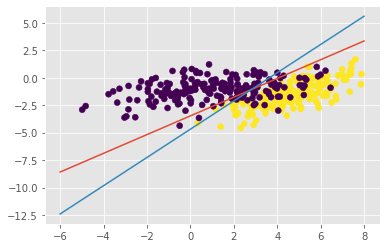

In [9]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_model = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=30, alpha=0.08, C=200, batch_size=30)
my_model.fit(X, 2*y-1)
plot_decision_boundary(my_model)

my_model = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=30, alpha=0.08, C=200, batch_size=30)
my_model.fit(X, y)
plot_decision_boundary(my_model)
plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [171]:
## Your Code Here
alphas = np.linspace(0.1, 1, 5)
N = 100

In [172]:
alpha_loss_log = []
for alpha in alphas:
    mean_loss = []
    clf = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=20, C=1000, alpha=alpha, batch_size=100)
    clf.fit(X, y)
    loss = np.array(clf.errors_log['loss'])
    for i in range (loss.shape[0] // N):
        mean_loss.append(loss[i * N : (i + 1) * N].mean())
    alpha_loss_log.append(mean_loss)
    print(alpha)

0.1
0.325
0.55
0.775
1.0


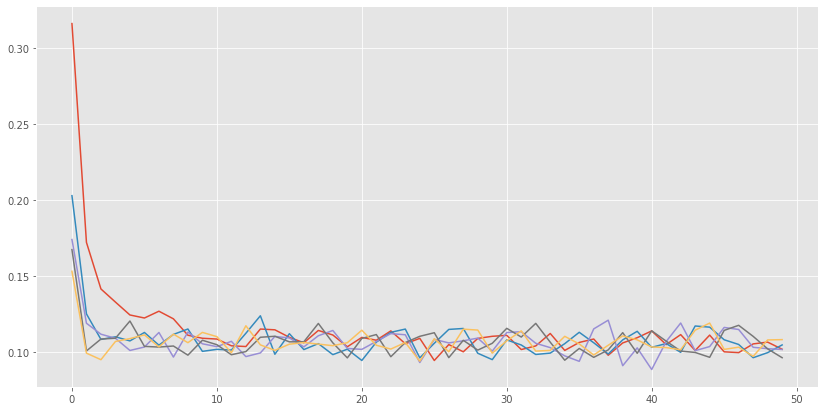

In [173]:
fig = plt.figure(figsize= (14, 7))
ax = plt.subplot()
for i in range(0, 5):
    ax.plot(alpha_loss_log[i][:50])

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

In [167]:
# Стоит выбирать значения alpha около 0.3
# При слишком маленьких alpha  (~ 0.001) для обучения требуется много эпох
# При больших alpha ( > 1) получаем большую ошибку

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [17]:
## Your Code Here
logw_mean = []
linw_mean = []
for C in np.logspace(3, -3, 10):
    clf = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=100, C=C, alpha=0.01, batch_size=10000)
    clf.fit(X, y)
    logw_mean.append(clf.weights.mean())
    clf = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=100, C=C, alpha=0.01, batch_size=10000)
    clf.fit(X, 2*y-1)
    linw_mean.append(clf.weights.mean())
    print(C)

1000.0
215.44346900318845
46.4158883361278
10.0
2.1544346900318843
0.4641588833612782
0.1
0.021544346900318867


/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in true_divide


0.004641588833612782
0.001


In [18]:
logw_mean, linw_mean

([-0.05374892518562016,
  -0.04833204796431211,
  -0.046803874237325814,
  -0.03306209683857421,
  -0.020217120144488256,
  -0.008390771592588277,
  -0.002197296522337356,
  -0.00027342805390658887,
  nan,
  nan],
 [-0.016607462369591097,
  -0.017273937267260932,
  -0.012195536279947199,
  -0.01643483229869738,
  -0.014015180533960949,
  -0.010981839528227249,
  -0.006902962118902684,
  -0.002040668320153136,
  0.00021924257256832508,
  -3.069896385784177e-05])

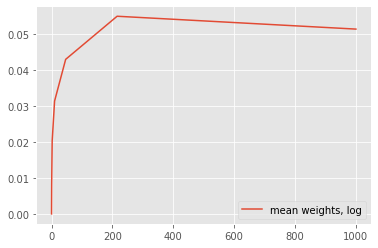

In [15]:
x_log = np.logspace(3, -3, 10)
y_log = np.abs(np.array(logw_mean))
plt.plot(x_log, y_log, label='mean weights, log')
plt.legend()
plt.show()

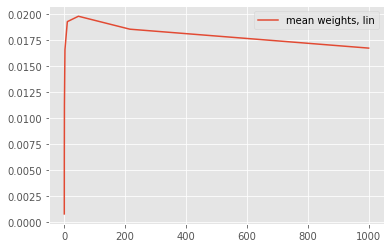

In [16]:
x_lin = np.logspace(3, -3, 10)
y_lin = np.abs(np.array(linw_mean))
plt.plot(x_lin, y_lin, label='mean weights, lin')
plt.legend()
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [7]:
import codecs

In [23]:
doc_to_title = {}
with codecs.open('docs_titles.tsv', 'r', 'utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [24]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [35]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [26]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [36]:
X_train = StandardScaler().fit_transform(X_train)

In [843]:
for batch_size in range(10, 840, 20):
    clf = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=30, C=0.01, alpha=0.01, batch_size=batch_size)
    %time clf.fit(X_train, y_train)

Wall time: 1.76 s
Wall time: 695 ms
Wall time: 529 ms
Wall time: 398 ms
Wall time: 371 ms
Wall time: 306 ms
Wall time: 282 ms
Wall time: 271 ms
Wall time: 263 ms
Wall time: 281 ms
Wall time: 279 ms
Wall time: 233 ms
Wall time: 217 ms
Wall time: 264 ms
Wall time: 296 ms
Wall time: 274 ms
Wall time: 266 ms
Wall time: 300 ms
Wall time: 321 ms
Wall time: 225 ms
Wall time: 230 ms
Wall time: 224 ms
Wall time: 203 ms
Wall time: 236 ms
Wall time: 225 ms
Wall time: 263 ms
Wall time: 225 ms
Wall time: 258 ms
Wall time: 236 ms
Wall time: 241 ms
Wall time: 224 ms
Wall time: 229 ms
Wall time: 221 ms
Wall time: 193 ms
Wall time: 231 ms
Wall time: 224 ms
Wall time: 187 ms
Wall time: 228 ms
Wall time: 214 ms
Wall time: 187 ms
Wall time: 234 ms
Wall time: 201 ms


In [ ]:
# batch_size = 800

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [52]:
alphas = np.linspace(0.01, 0.35, 7)
c_values = np.logspace(3, -2, 5)
max_epochs = [5, 10]
model_types = ['log_reg', 'lin_reg']

In [53]:
max_epochs, alphas, c_values

([5, 10], array([0.01      , 0.06666667, 0.12333333, 0.18      , 0.23666667,
        0.29333333, 0.35      ]), array([1.00000000e+03, 5.62341325e+01, 3.16227766e+00, 1.77827941e-01,
        1.00000000e-02]))

In [55]:
best_score = 0
test_params = np.empty((5, 7, 2, 90, 2))
for j in range(5):
    C = c_values[j]
    for k in range(7):
        alpha = alphas[k]
        for l in range(2):
            max_epoch = max_epochs[l]
            params = [C, alpha, max_epoch]
            print(params)
            lin_clf = MySGDClassifier(batch_generator, C, alpha, max_epoch, model_type='lin_reg', batch_size=800)
            log_clf = MySGDClassifier(batch_generator, C, alpha, max_epoch, model_type='log_reg', batch_size=800)
            tres_scores = np.empty((129, 90, 2))
            for i in range(129):
                ind_test = np.where(groups_train == i)
                ind_train = np.where(groups_train != i)
                X = X_train[ind_train]
                X_test = X_train[ind_test]
                y = y_train[ind_train]
                y_test = y_train[ind_test]
                y_lin = y * 2 - 1
                lin = lin_clf.fit(X, y_lin).predict(X_test)
                lin = (lin + 1) / 2
                log = log_clf.fit(X, y).predict(X_test)
                treshold = 0.01
                for t in range(90):
                    threshold = 0.01 * (t + 1)
                    lin_pred = np.empty_like(lin)
                    log_pred = np.empty_like(log)
                    lin_pred[lin > threshold] = 1
                    lin_pred[lin <= threshold] = 0
                    log_pred[log > threshold] = 1
                    log_pred[log <= threshold] = 0
                    tres_scores[i][t][0] = f1_score(y_test, lin_pred)
                    tres_scores[i][t][1] = f1_score(y_test, log_pred)
            m = tres_scores.mean(axis=0)
            test_params[j][k][l] = m 

[1000.0, 0.01, 5]
[1000.0, 0.01, 10]
[1000.0, 0.06666666666666667, 5]
[1000.0, 0.06666666666666667, 10]
[1000.0, 0.12333333333333332, 5]
[1000.0, 0.12333333333333332, 10]
[1000.0, 0.18, 5]
[1000.0, 0.18, 10]
[1000.0, 0.23666666666666666, 5]
[1000.0, 0.23666666666666666, 10]
[1000.0, 0.29333333333333333, 5]
[1000.0, 0.29333333333333333, 10]
[1000.0, 0.35, 5]
[1000.0, 0.35, 10]
[56.23413251903491, 0.01, 5]
[56.23413251903491, 0.01, 10]
[56.23413251903491, 0.06666666666666667, 5]
[56.23413251903491, 0.06666666666666667, 10]
[56.23413251903491, 0.12333333333333332, 5]
[56.23413251903491, 0.12333333333333332, 10]
[56.23413251903491, 0.18, 5]
[56.23413251903491, 0.18, 10]
[56.23413251903491, 0.23666666666666666, 5]
[56.23413251903491, 0.23666666666666666, 10]
[56.23413251903491, 0.29333333333333333, 5]
[56.23413251903491, 0.29333333333333333, 10]
[56.23413251903491, 0.35, 5]
[56.23413251903491, 0.35, 10]
[3.1622776601683795, 0.01, 5]
[3.1622776601683795, 0.01, 10]
[3.1622776601683795, 0.0666

C:\Users\Mi\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
C:\Users\Mi\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply


[0.1778279410038923, 0.18, 10]
[0.1778279410038923, 0.23666666666666666, 5]
[0.1778279410038923, 0.23666666666666666, 10]
[0.1778279410038923, 0.29333333333333333, 5]
[0.1778279410038923, 0.29333333333333333, 10]
[0.1778279410038923, 0.35, 5]
[0.1778279410038923, 0.35, 10]
[0.01, 0.01, 5]
[0.01, 0.01, 10]
[0.01, 0.06666666666666667, 5]
[0.01, 0.06666666666666667, 10]
[0.01, 0.12333333333333332, 5]
[0.01, 0.12333333333333332, 10]


C:\Users\Mi\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars


[0.01, 0.18, 5]
[0.01, 0.18, 10]
[0.01, 0.23666666666666666, 5]
[0.01, 0.23666666666666666, 10]
[0.01, 0.29333333333333333, 5]
[0.01, 0.29333333333333333, 10]
[0.01, 0.35, 5]
[0.01, 0.35, 10]


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [57]:
params = np.array(test_params)

In [77]:
np.unravel_index(np.argmax(params[:,:,:,:,0]), params[:,:,:,:,0].shape)

(0, 4, 0, 22)

In [76]:
params[0,0,0,38,1]

0.45161412902606307

In [83]:
[c_values[0], alphas[0], max_epochs[0], 0.39, 'log_reg']

[1000.0, 0.01, 5, 0.39, 'log_reg']

In [78]:
params[0,4,0,22,0]

0.45096777769214635

In [84]:
[c_values[0], alphas[4], max_epochs[0], 0.21, 'lin_reg']

[1000.0, 0.23666666666666666, 5, 0.21, 'lin_reg']

In [123]:
best_params

[10.0, 0.28, 0.2, 'log_reg', 0.39]

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

https://www.kaggle.com/yurchenko
Artem Yurchenko

In [88]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [89]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


In [117]:
my_clf = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=2, alpha=0.28, C=10, batch_size = 800)
my_clf.fit(X_train, y_train)

MySGDClassifier(C=10, alpha=0.28,
                batch_generator=<function batch_generator at 0x0000021825312948>,
                batch_size=800, max_epoch=2, model_type='log_reg')

In [114]:
myclf = MySGDClassifier(batch_generator, C=6, alpha=0.25, max_epoch=3, model_type='log_reg', batch_size=1000)
myclf.fit(X_train, y_train)

MySGDClassifier(C=6, alpha=0.25,
                batch_generator=<function batch_generator at 0x0000021825312948>,
                batch_size=1000, max_epoch=3, model_type='log_reg')

In [101]:
my_clf = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=5, alpha=0.23666666666666666, C=1000, batch_size = 800)
my_clf.fit(X_train, y_train)

MySGDClassifier(C=1000, alpha=0.23666666666666666,
                batch_generator=<function batch_generator at 0x0000021825312948>,
                batch_size=800, max_epoch=5, model_type='lin_reg')

In [93]:
my_clf = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=5, alpha=0.01, C=1000, batch_size = 800)
my_clf.fit(X_train, y_train)

MySGDClassifier(C=1000, alpha=0.01,
                batch_generator=<function batch_generator at 0x0000021825312948>,
                batch_size=800, max_epoch=5, model_type='log_reg')

In [94]:
X_test = StandardScaler().transform(X_test)

In [118]:
import csv
y_pred = my_clf.predict(X_test)
# y_pred = (y_pred+1) / 2
y_pred[y_pred > 0.39] = 1
y_pred[y_pred <= 0.39] = 0
y_pred = np.array(y_pred, dtype=np.int)
with open('sample_submission.csv', 'w') as f:
    fieldnames = ['pair_id', 'target']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    i = 11691
    for elem in y_pred:
        writer.writerow({'pair_id': str(i), 'target': str(elem)})
        i += 1
f.close()


In [121]:
y_pred.mean()

0.26246466590485357

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

In [ ]:
# Хотелось бы больше советов о способах подбора подходящих параметров